# Reinforcement Learning: Learning to Play Tic-Tac-Toe with Value Iteration

## Introduction 
 
Value iteration is a model-based method that uses dynamic programming to find the optimal value function $V^*$ and then extracts the optimal policy $\pi^*$.


Model-based method assumes that we know the transition model and the reward model of the MDP. 

* Transition model $p(s'|s,a)$ has $|S|\times|S|\times|A|$ entries.
* Reward model is a function $r(s,a,s')$ has $|S|\times|S|\times|A|$ entries.

We can implement these as functions, or, if they fit in memory, as lists of precomputed matrices.

We first check how large the state space is, then we discover the state spave and set up the MDP. Then we implement value iteration and experiment with the resulting value function and policy.

Install missing libraries.

In [41]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## State Space

### State Space Size

Value iteration iteratively calculates a Value function $V$ and then extracts a policy $pi$ that prescribes for each state an action. It is therefore a table of
size $|S|$. For this completely observable problem, state and observation are the same.

We need to make sure that the policy table fits in memory.

In [42]:
import math

print("level\tboards\tplayer")
sum = {"x":0, "o":0}
player = "x"

for i in range(0,10):
    # unique states at each level:
    # how many different squares can be played played times how we can split them between x and o
    boards = math.comb(9, i) * math.comb(i, math.floor(i/2))
    print(i, "\t", boards, "\t", player)
    
    sum[player] += boards

    if player == "x": 
        player = "o" 
    else: 
        player = "x"

print (f"Number of boards by player: {sum}")

level	boards	player
0 	 1 	 x
1 	 9 	 o
2 	 72 	 x
3 	 252 	 o
4 	 756 	 x
5 	 1260 	 o
6 	 1680 	 x
7 	 1260 	 o
8 	 630 	 x
9 	 126 	 o
Number of boards by player: {'x': 3139, 'o': 2907}


Some games will end early, so everything should easily fit into memory. 

### Finding the State Space

We need the state space for model-based RL methods. We can find all reachable states by performing a depth-first traversal using the result function. 
We focus here on player `x`. Note that states for player `x` are only boards where it is `x`'s move or where the game is complete.  

In [43]:
# load game mechanics
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
import numpy as np


This is a dept-first traversal of the game tree and store all encountered boards by player. We store information on what player moves next, if the state is terminal and the immediate reward for the state since we will 
need it to define the MDP.

In [44]:
def traverse_boards(reward_player = "x"):
    boards = dict()

    def move(board, player):
        # print("Traversing state", state, "for player", player)
        for action in actions(board):
            next_board = result(board, player, action)
            if tuple(next_board) not in boards:  
                if terminal(next_board):
                    boards[tuple(next_board)] = { "player" : "terminal", "reward" : utility(next_board, reward_player) } 
                else:
                    boards[tuple(next_board)] = { "player" : other(player), "reward" : 0.0 }
                    move(next_board, other(player))
                

    start_board = empty_board()
    boards[tuple(start_board)] = { "player" : "x", "reward" : 0.0 }
    move(start_board, "x")
  
    return boards

In [45]:
boards = traverse_boards()
print("Total unique boards (for player x, o and terminal):", len(boards.keys()))

# filter states for player 'x' to get the state space S
S_non_terminal = [state for state in boards.keys() if boards[state]["player"] == "x"]
print("Total unique states for player 'x' excluding terminal boards:", len(S_non_terminal))

S = [state for state in boards.keys() if boards[state]["player"] == "x" or boards[state]["player"] == "terminal"]
print("Total unique states for player 'x' including terminal boards:", len(S))

display(S[0:5])  # print first 5 states for player 'x'

# compare counts with the combinatorial calculation
a = np.array([s.count("x") + s.count("o") for s in S])
unique, counts = np.unique(a, return_counts=True)
display(dict(zip(unique, counts)))

Total unique boards (for player x, o and terminal): 5478
Total unique states for player 'x' excluding terminal boards: 2423
Total unique states for player 'x' including terminal boards: 3381


[(' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
 ('x', 'o', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
 ('x', 'o', 'x', 'o', ' ', ' ', ' ', ' ', ' '),
 ('x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '),
 ('x', 'o', 'x', 'o', 'x', 'o', 'x', ' ', ' ')]

{np.int64(0): np.int64(1),
 np.int64(2): np.int64(72),
 np.int64(4): np.int64(756),
 np.int64(5): np.int64(120),
 np.int64(6): np.int64(1520),
 np.int64(7): np.int64(444),
 np.int64(8): np.int64(390),
 np.int64(9): np.int64(78)}

Since we show the agent the terminal board at the end of the game, it is a valid terminal state and part of the state space.

Check a few boards

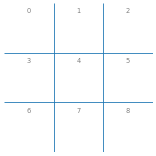

{'player': 'x', 'reward': 0.0}

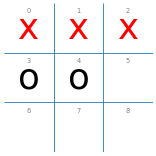

{'player': 'terminal', 'reward': 1}

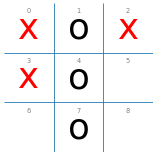

{'player': 'terminal', 'reward': -1}

In [46]:
b = [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
show_board(b)
display(boards[tuple(b)]) 

b = ['x', 'x', 'x', 'o', 'o', ' ', ' ', ' ', ' ']
show_board(b)
display(boards[tuple(b)]) 

b = ['x', 'o', 'x', 'x', 'o', ' ', ' ', 'o', ' ']
show_board(b)
display(boards[tuple(b)]) 

Let's check the immediate reward distribution.

Count of unique values: {np.float64(-1.0): np.int64(316), np.float64(0.0): np.int64(4536), np.float64(1.0): np.int64(626)}


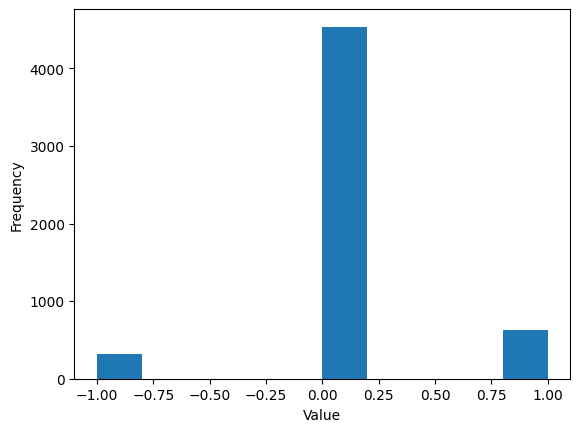

In [47]:
import matplotlib.pyplot as plt

r = [r["reward"] for r in boards.values()]

unique_elements, counts = np.unique(r, return_counts=True)
print(f"Count of unique values: {dict(zip(unique_elements, counts))}")

plt.hist(r, bins=10)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## Transition and Reward Model

We define the MDP's transition and reward model as methods in a class. We will precompute the transition model and the reward model as lists of matrices for each action. We do this so the algorithm runs faster using matrix multiplications.

Let's see how much memory we need.

In [48]:
A = [0, 1, 2, 3, 4, 5, 6, 7, 8]

entries = len(S) * len(S) * len(A)
print(f"Number of entries in the transaction model: {entries}")

# for np.float64 = 4 bytes
print(f"Memory needed in MB: {entries*4/1024/1024}")

Number of entries in the transaction model: 102880449
Memory needed in MB: 392.45776748657227


We need this twice (plus some minimal data structure overhead), once for the transaction model and once for the matrices in the reward model. Less then 1 GB fits easily into memory. 

__Implementation__

* $p(s'|s,a)$ is implemented as a list one element for each action. The elements are matrices representing the transition $s \rightarrow s'$.
* $r(s,a,s')$ is implemented as a list one element for each action. The elements are matrices representing the transition $s \rightarrow s'$.

__Important issues for the transition model:__
* Illegal actions: We define that the agent stays in its state with a probability of 1.
* Terminal states: We define that the agent stays in the terminal state with a probability of 1 no matter the action. This is an absorbing state.
* Opponents actions: We define here that the opponent pursues a random policy and chooses uniformly from the available actions.

__Important issues for the reward model:__
* The reward is for entering a state so it focuses on $s'$.
* Illegal actions: These are forbidden with a reward of $-\infty$. However since python has issues with multiplying infinity with 0, we use a large negative immediate reward.
* Terminal states: The argent only gets a reward for entering the terminal state (winning or losing the game). When it stays in the absorbing state the 
    immediate reward will be 0. 


# Defining the MDP

We need model access for the transition model and the reward model.

In [49]:
class MDPModel:
    def __init__(self, player = "x"):
        """initialize the MDP model with state space S and the player to move"""
        self.player = player
        
        # actions
        self.A = [0,1,2,3,4,5,6,7,8]

        print("Exploring the state space...")
        self.boards = traverse_boards()
        
        # S is a hashed in dictionary S_lookup state -> id for faster lookup
        S = [state for state in self.boards.keys() if self.boards[state]["player"] == self.player or self.boards[state]["player"] == "terminal"] 
        self.S = S
        self.S_lookup = dict(zip(S, range(len(S))))
        print(f"Total unique states for player {self.player} including terminal boards: {len(self.S)}")
        
        print("Precomputing transition matrices...")
        # make access to transition probabilities faster by precomputing them
        self.p = None
        self.p = self.transition_matrix_list()
        
        # make access to rewards faster by precomputing them for all actions
        print("Precomputing reward matrix...")
        self.r = None
        self.r = self.reward_matrix_list()

        print("Done.")

    
    def get_state_id(self, state):
        """returns the id of a state in S used for indexing into arrays and matrices"""
        if isinstance(state, (int, float)):
            return state # already an id
        
        if tuple(state) not in self.S_lookup:
            raise ValueError(f"State {state} not in state space S")
        
        return self.S_lookup[tuple(state)]
    
    def get_state(self, state_id):
        """returns the state for a given id in S"""
        if not isinstance(state_id, int) or state_id < 0 or state_id >= len(self.S):
            raise ValueError(f"State id {state_id} not in state space S")
        
        # reverse lookup
        return self.S[state_id]
    
    def transition_probability(self, state, action):
        """returns a vector p of length |S| with the transition probabilities
        p[s'] = p(s' | state, action) for all s' in S
        """

        state_id = self.get_state_id(state)

        # use precomputed matrix if available
        if self.p is not None and action in self.p:
            return self.p[action][state_id, :]  

        p = np.zeros(len(self.S))
        
        # stay in place if the game is over or the action is not valid
        if terminal(state) or action not in actions(state):
            p[state_id] = 1.0
            return p

        # the agent
        next_state = result(list(state), self.player, action)
        if terminal(next_state):
            if tuple(next_state) not in self.S:
                print(f"state {state}, next_state {next_state}, action {action} not in state space S")
                raise ValueError(f"Next state {next_state} not in state space S")
            
            p[self.get_state_id(next_state)] = 1.0
            return p
        
        # the opponent (we assume random play)
        next_states = [result(next_state, other(self.player), a) for a in actions(next_state)]

        for next_state in next_states:
            p[self.get_state_id(next_state)] += 1.0 / len(next_states)
        
        return p
    
    def transition_matrix(self, action):
        """returns the full transition matrix P for and action  
        with P[s, s'] = p(s' | s, action) for all s, s' in S
        """

        # use precomputed matrix if available
        if self.p is not None and action in self.p:
            return self.p[action]   

        p_matrix = np.zeros(shape=(len(self.S), len(self.S)))
        for i, s in enumerate(self.S):
            p = self.transition_probability(s, action)
            p_matrix[i, :] = p

        return p_matrix

    def transition_matrix_list(self):
        """returns the full transition matrix P as a list of matrices for each action a in A
        with P[a][s, s'] = p(s' | s, a) for all s, s' in S and a in A
        """
        if self.p is not None:
            return self.p
    
        P = dict()
        for a in self.A:
            P[a] = self.transition_matrix(action=a)

        return P

    def reward(self, state, action, next_state):
        """returns the reward for a state.
        For this game only the state we get to (a win or loss) counts for the reward so we have R(s,a,s') = R(s,s')"""
        
        state_id = self.get_state_id(state)
        next_state_id = self.get_state_id(next_state)
        
        if self.boards[tuple(state)]["player"] == "terminal":
            return 0.0 

        # illegal moves are forbidden
        if state == next_state:
            # return -np.inf
            # unfortunately Python has issues with -inf * 0 being not defined
            # so we use a large negative number instead.
            return -1e6 
        
        # use precomputed matrix if available
        if self.r is not None and action in self.r:
            return self.r[action][state_id, next_state_id]  

        return self.boards[tuple(next_state)]["reward"]
    
    def reward_vector(self, state, action):
        """returns a vector r of length |S| with the rewards
        r[s'] = R(state, action, s') for all s' in S
        """

        r = [self.reward(state, action, s) for s in self.S]
        return r

    def reward_matrix(self, action):
        """returns the reward matrix R[s,s'] for action a"""
        # use precomputed matrix if available
        if self.r is not None and action in self.r:
            return self.r[action]
    
        r_matrix = np.zeros(shape=(len(self.S), len(self.S)))
        for i, s in enumerate(self.S):
            r = self.reward_vector(s, action)
            r_matrix[i, :] = r

        return r_matrix
    
    def reward_matrix_list(self):
        """returns the reward vector R with R[s] = R(s) for all s in S"""
        if self.r is not None:
            return self.r
        
        # reward does not depend on action in this game
        r_matrix = self.reward_matrix(action=None)

        R = dict() 
        for a in self.A:
            R[a] = r_matrix

        return R


Create the model and precaluclating all the matrices takes a while!

In [50]:
mdp = MDPModel(player="x")

Exploring the state space...
Total unique states for player x including terminal boards: 3381
Precomputing transition matrices...
Precomputing reward matrix...
Done.


Make sure the entries in the transition model makes sense.

In [51]:
b = empty_board()

p = mdp.transition_probability(b, 0)
display(f"Transition vector: {p}")  
print(f"Vector sums to {p.sum()} (should be 1)") 

m = mdp.transition_matrix(0)  # transition matrix for action 0 from board b
print(f"\nTransition matrix:\n{m}")

colsums = np.round(np.sum(m, axis=1), 3) 
print(f"Do all rows add up to 1? {all(colsums == 1.0)}")

'Transition vector: [0.    0.125 0.    ... 0.    0.    0.   ]'

Vector sums to 1.0 (should be 1)

Transition matrix:
[[0.    0.125 0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
Do all rows add up to 1? True


Look at some entries in the reward model.

array([[-1000000.,        0.,        0., ...,        0.,        0.,
               0.],
       [       0., -1000000.,        0., ...,        0.,        0.,
               0.],
       [       0.,        0., -1000000., ...,        0.,        0.,
               0.],
       ...,
       [       0.,        0.,        0., ..., -1000000.,        0.,
               0.],
       [       0.,        0.,        0., ...,        0., -1000000.,
               0.],
       [       0.,        0.,        0., ...,        0.,        0.,
        -1000000.]], shape=(3381, 3381))


Current board: ['x', 'o', ' ', 'x', 'o', ' ', ' ', ' ', ' ']


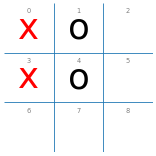

Reward after playing 6: 1.0


In [52]:
r = mdp.reward_matrix(action=0)
display(r)


b = ['x', 'o', ' ', 'x', 'o', ' ', ' ', ' ', ' ']
print(f"\nCurrent board: {b}")
show_board(b)

# Playing action 6 leads to a win (terminal state)
b_next = result(b, "x", 6) 
r = mdp.reward(b, 6, b_next)
print(f"Reward after playing 6: {r}")

Now, since we have access to the MDP model, we can implement model-based RL methods.

# Implement Value Iteration

![Value Iteration](figures/RL_VI.png)

Page 83 of the RL text book. We use here $p(s'|s,a)$ and $r(s,a,S')$ instead of $p(s',r|s,a)$ because the reward model is determinisitic.

The implementation follows exactly the pseudo code from the RL text book.

In [53]:
def value_iteration(mdp, gamma=1, theta=1e-6, max_iterations=100, verbose = True):
    """Value Iteration algorithm for MDPs
    mdp: an MDP model with methods transition_probability(state, action) and reward(state, action, next_state)
    gamma: discount factor
    theta: threshold for stopping criterion
    returns: V, a dictionary mapping states to values
    """
    
    # note: the algorithm uses state ids (integers) instead of states for faster access
    # get model components for faster access
    r = mdp.reward_matrix_list()
    p = mdp.transition_matrix_list()
    A = mdp.A
    S = mdp.S
    
    V = np.zeros(len(S)) # initialize value function to 0 for all states

    i = 0
    while True:
        i += 1
        if verbose:
            print(f"Iteration {i}")
     
        delta = 0.0
        for s in range(len(S)):
            v = V[s]
            # instead of p(s',r|s,a) we have  p(s'|s,a) and r(s,a,s')
            V[s] = np.max([np.sum(p[a][s, :] * (r[a][s, :] + gamma * V)) for a in A])
            delta = max(delta, abs(v - V[s]))
        
        if verbose:
            print(f"V (min/max) {np.min(V)}/{np.max(V):.2f}")
            print(f"Max change in value function delta: {delta}")
        
        if delta < theta:
            break

        if i >= max_iterations:
            if verbose:
                print("Maximum iterations reached")
            break

        # calculate the policy
        pi = np.zeros(len(S))
        for s in range(len(S)):
            # note: np.argmax does not break ties randomly, but returns the first!
            pi[s] = np.argmax([np.sum(p[a][s, :] * (r[a][s, :] + gamma * V)) for a in A])

    return V, pi

In [54]:
V, pi = value_iteration(mdp, gamma=1, theta=1e-6, max_iterations=100)

Iteration 1
V (min/max) -1.0/1.00
Max change in value function delta: 1.0
Iteration 2
V (min/max) -1.0/1.00
Max change in value function delta: 1.0
Iteration 3
V (min/max) -1.0/1.00
Max change in value function delta: 0.125
Iteration 4
V (min/max) -1.0/1.00
Max change in value function delta: 0.0


Let's look at the optimal value function $V^*$.

In [55]:
V

array([0.99479167, 1.        , 1.        , ..., 1.        , 1.        ,
       1.        ], shape=(3381,))

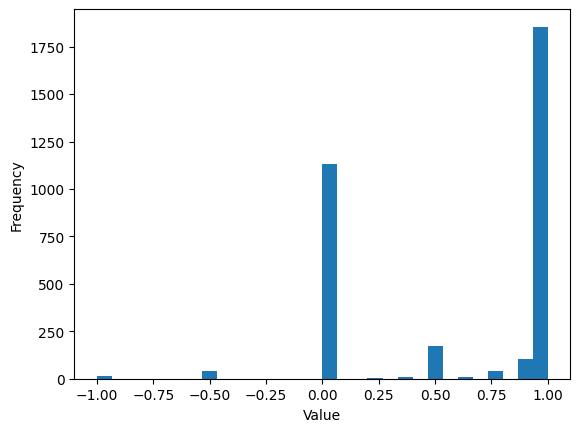

In [56]:
import matplotlib.pyplot as plt

plt.hist(V, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

There are some boards which create a immediate reward of -1. Let's see how they look like.

[ 522  557 1010 1186 1274 1502 1582 1812 1859 1873 2461 2598 2624 2660
 2748 3179]


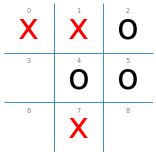

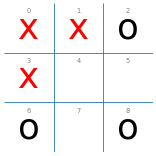

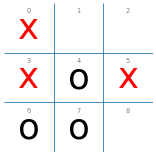

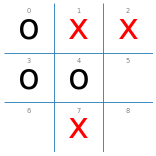

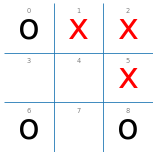

In [57]:
bad = np.where(V == -1)[0]
print(bad)

for b in bad[0:5]:
    show_board(mdp.S[b]) 


Luckily, if we follow the optimal policy, then we will never get to one of these boards.

Here is the optimal policy $\pi^*$.

In [58]:
pi

array([0., 3., 4., ..., 6., 0., 5.], shape=(3381,))

# Experiments

We will try a few boards and look at the value and the action prescribed by the policy.

### Empty Board

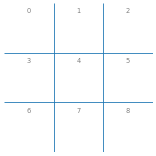

V(s) = 0.9947916666666666; pi(s) = 0.0


In [59]:
board = empty_board() 
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")


Observations: 
* We have determined the optimal policy for `x` and `o` plays randomly. For tic-tac-toe this means that `x`
  can never lose and the minimum reward is 0. For the first move, `x` will most likely win against `o` with a value close to 1.
* The `np.argmax()` implementation always returns action 0 when all rewards are the same. This happens for the first move and for terminal boards.

### Ready for a Trap

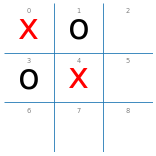

V(s) = 1.0; pi(s) = 2.0


In [60]:

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")

Observations:
* We do not use discounting so 2, 6, 8 lead to the same reward and it picks the first action.

### Terminal Win Board

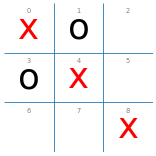

V(s) = 0.0; pi(s) = 0.0


In [61]:
board[8] = 'x'
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")

Observations:
* No legal actions. arg.max returns action 0.
* Terminal states have by definition a value of 0.

### Avoided Loss

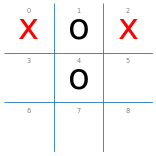

V(s) = 0.5; pi(s) = 7.0


In [62]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")

### Lost Board

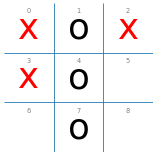

V(s) = 0.0; pi(s) = 0.0


In [63]:
board[3] = 'x'
board[7] = 'o'
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")

Observations:
* No legal actions. arg.max returns action 0.
* Terminal states have by definition a value of 0.

### Bad Situation

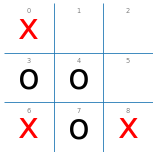

V(s) = -0.5; pi(s) = 1.0


In [64]:
board =  ['x', ' ', ' ', 'o', 'o', ' ', 'x', 'o', 'x']
show_board(board)
print(f"V(s) = {V[mdp.get_state_id(board)]}; pi(s) = {pi[mdp.get_state_id(board)]}")

Observations:
* `x` has no chance, but since `o` plays randomly it still has a 50% chance of messing it up.